In [1]:
import os

import click
from os.path import  join, isdir
from plan import Plan
from action import Action
from utils import load_from_folder
from multiprocess import Pool


2025-08-09 15:04:35.077898: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-09 15:04:35.106435: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754744675.130732 2490029 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754744675.137941 2490029 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1754744675.163037 2490029 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
save_dir = './results/'
data_base_dir = '../datasets/'
domain = 'logistics'
results_dir = f"{save_dir}/{domain}/"   
source_dir = f"../datasets/gr_logistics/pickles" 
print('Domain dir:', source_dir)
os.makedirs(save_dir, exist_ok=True)
os.makedirs(results_dir, exist_ok=True)


Domain dir: ../datasets/gr_logistics/pickles


Data load

In [3]:
splits = {}
train_plans = load_from_folder(source_dir,["train_plans"])
train_plans = train_plans[0]
val_plans = load_from_folder(source_dir,["val_plans"])
val_plans = val_plans[0]
test_plans = load_from_folder(source_dir,["test_plans"])
test_plans = test_plans[0]

splits["train_plans"] = train_plans
splits["val_plans"] = val_plans
splits["test_plans"] = test_plans


train_plans loaded from ../datasets/gr_logistics/pickles
val_plans loaded from ../datasets/gr_logistics/pickles
test_plans loaded from ../datasets/gr_logistics/pickles


Data analysis

In [4]:
print(f"Train plans: {len(train_plans)}")
print(f"Val plans: {len(val_plans)}")
print(f"Test plans: {len(test_plans)}")

Train plans: 47612
Val plans: 5601
Test plans: 2802


In [11]:
for split in splits:
    print(f"{split}: Number of plans: {len(splits[split])}")        

train_plans: Number of plans: 47612
val_plans: Number of plans: 5601


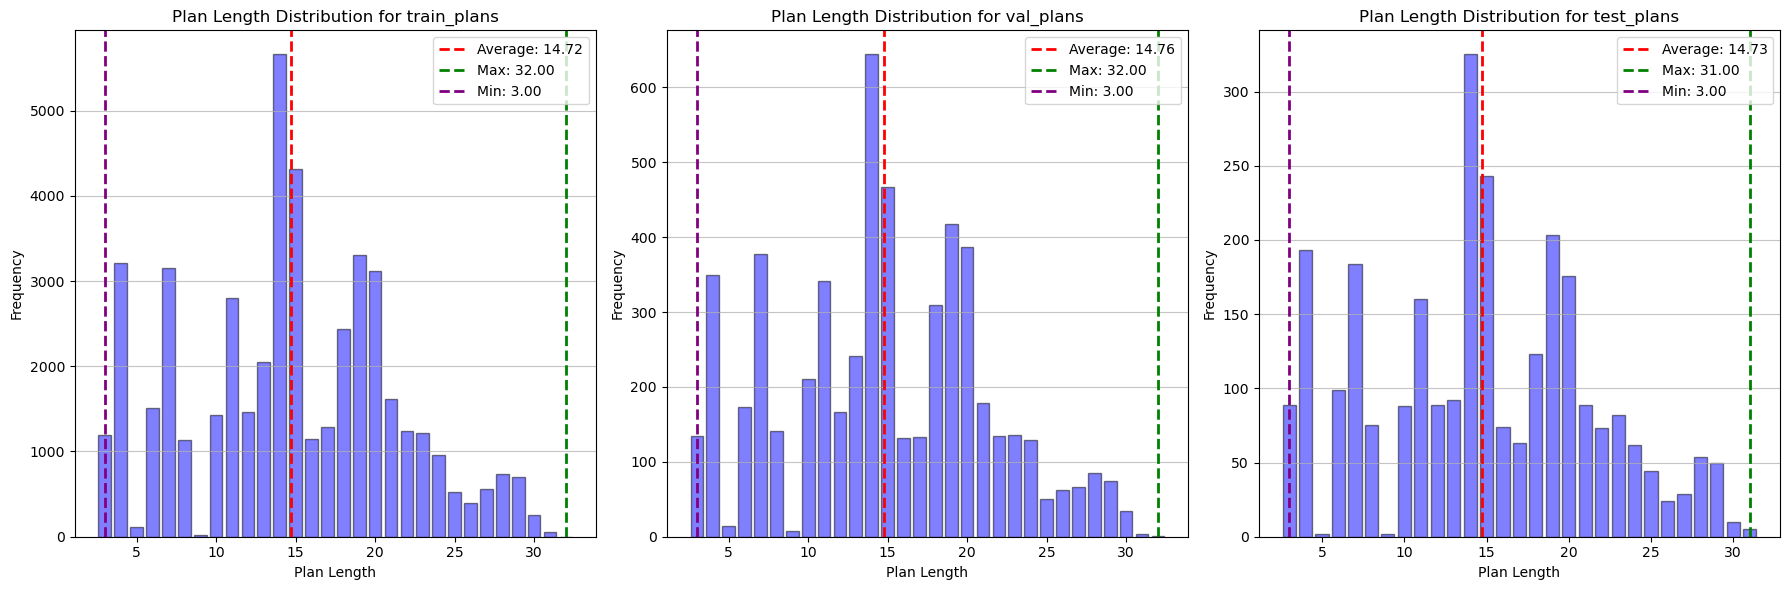

In [14]:
import numpy as np
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, len(splits), figsize=(6 * len(splits), 6))
if len(splits) == 1:
    axs = [axs]
for ax, (split, plans) in zip(axs, splits.items()):
    plan_lengths = [len(plan.actions) for plan in plans]
    frequency = {}
    for length in plan_lengths:
        frequency[length] = frequency.get(length, 0) + 1
    avg_length_local = np.mean(plan_lengths)
    med_length_local = np.median(plan_lengths)
    max_length_local = np.max(plan_lengths)
    min_length_local = np.min(plan_lengths)
    perc75 = np.percentile(plan_lengths, 75)
    perc99 = np.percentile(plan_lengths, 99)
    ax.bar(frequency.keys(), frequency.values(), color='blue', alpha=0.5, edgecolor='black')
    ax.axvline(x=avg_length_local, color='red', linestyle='--', linewidth=2, label=f'Average: {avg_length_local:.2f}')
    ax.axvline(x=max_length_local, color='green', linestyle='--', linewidth=2, label=f'Max: {max_length_local:.2f}')
    ax.axvline(x=min_length_local, color='purple', linestyle='--', linewidth=2, label=f'Min: {min_length_local:.2f}')
    ax.set_title(f"Plan Length Distribution for {split}")
    ax.set_xlabel("Plan Length")
    ax.set_ylabel("Frequency")
    ax.grid(axis='y', alpha=0.75)
    ax.legend()
plt.tight_layout()
plt.savefig(f"{save_dir}/{domain}/{domain}_combined_plan_length_distribution.jpeg")
plt.show()

In [7]:
for split, plans in splits.items():
    print(f"Plan {plans[0].plan_name} for {split}:")
    for action in plans[0].actions:
        print(f"    {action}")
    print()

Plan p056285_1 for train_plans:
    drive-truck tru4 pos55 apt1 cit4
    load-truck obj11 tru3 pos77
    drive-truck tru3 pos77 pos23 cit3
    load-truck obj55 tru3 pos23
    drive-truck tru3 pos23 apt5 cit3
    unload-truck obj55 tru3 apt5
    unload-truck obj11 tru3 apt5
    load-airplane obj55 apn1 apt5
    load-airplane obj11 apn1 apt5
    fly-airplane apn1 apt5 apt1
    unload-airplane obj55 apn1 apt1
    load-truck obj55 tru4 apt1
    unload-airplane obj11 apn1 apt1
    load-truck obj11 tru4 apt1
    drive-truck tru4 apt1 pos12 cit4
    unload-truck obj55 tru4 pos12
    drive-truck tru4 pos12 pos55 cit4
    unload-truck obj11 tru4 pos55

Plan p014181_2 for val_plans:
    drive-truck tru5 pos55 apt5 cit3
    load-truck obj00 tru1 pos77
    drive-truck tru1 pos77 pos66 cit1
    load-truck obj33 tru1 pos66
    drive-truck tru1 pos66 apt7 cit1
    unload-truck obj33 tru1 apt7
    unload-truck obj00 tru1 apt7
    fly-airplane apn7 apt5 apt7
    load-airplane obj33 apn7 apt7
    load-a

In [15]:
for split, plans in splits.items():
    for plan in plans[:3]:
        print(f"Goals {plan.goals}:")
        print()

Goals ['at obj12 pos12', 'at obj66 pos12']:

Goals ['at obj33 pos13', 'at obj88 pos33']:

Goals ['at obj99 pos21', 'at obj22 pos22']:

Goals ['at obj21 pos11', 'at obj12 pos55']:

Goals ['at obj13 pos11', 'at obj23 pos44']:

Goals ['at obj21 pos66', 'at obj23 pos44', 'at obj88 pos11']:

Goals ['at obj22 pos55', 'at obj13 pos66']:

Goals ['at obj77 pos55', 'at obj44 pos55']:

Goals ['at obj23 pos77', 'at obj55 pos44']:



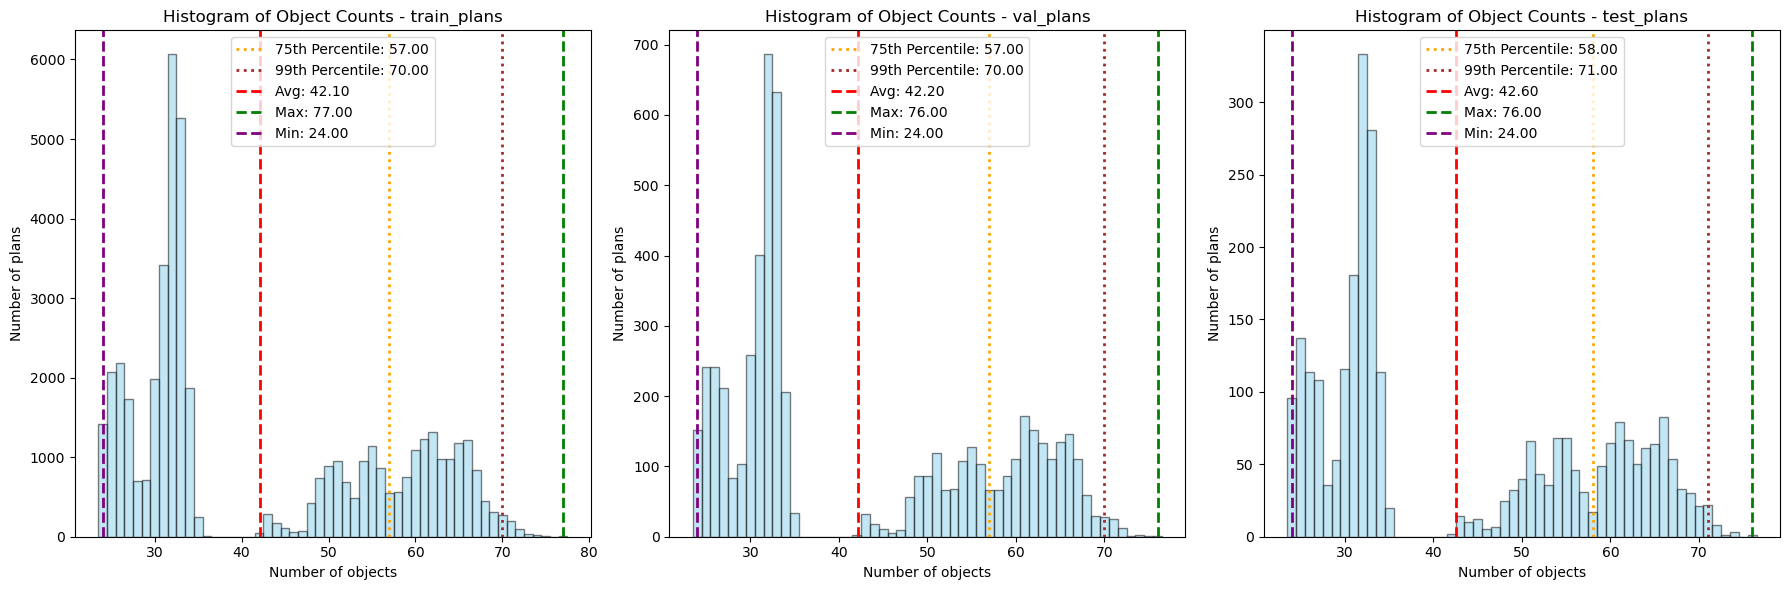

In [7]:
# counting plan init objects,
# how can i know all objects in the domain without the domain?
# try to explore the plan to find all objects involved
    
# create a combined figure with subplots for object count histograms
fig, axs = plt.subplots(1, len(splits), figsize=(6 * len(splits), 6))
if len(splits) == 1:
    axs = [axs]

for ax, (split, plans) in zip(axs, splits.items()):
    obj_numbers_list = []
    for plan in plans:
        obj_set = set()
        for text in plan.initial_state:
            for obj in text.split(" ")[1:]:
                obj_set.add(obj)
        for action in plan.actions:
                for obj in action.split(" ")[1:]:
                    obj_set.add(obj)
        obj_numbers_list.append(len(obj_set))
        
    bins = np.arange(min(obj_numbers_list), max(obj_numbers_list) + 2, 1)
    # bins = 20 #for logistics
    ax.hist(obj_numbers_list, bins=bins, color='skyblue', edgecolor='black', alpha=0.5, align='left')
    avg_val = np.mean(obj_numbers_list)
    max_val = np.max(obj_numbers_list)
    min_val = np.min(obj_numbers_list)
    perc75 = np.percentile(obj_numbers_list, 75)
    perc99 = np.percentile(obj_numbers_list, 99)
    ax.axvline(x=perc75, color='orange', linestyle=':', linewidth=2, label=f'75th Percentile: {perc75:.2f}')
    ax.axvline(x=perc99, color='brown', linestyle=':', linewidth=2, label=f'99th Percentile: {perc99:.2f}')
    ax.axvline(x=avg_val, color='red', linestyle='--', linewidth=2, label=f'Avg: {avg_val:.2f}')
    ax.axvline(x=max_val, color='green', linestyle='--', linewidth=2, label=f'Max: {max_val:.2f}')
    ax.axvline(x=min_val, color='purple', linestyle='--', linewidth=2, label=f'Min: {min_val:.2f}')

    ax.set_title(f"Histogram of Object Counts - {split}")
    ax.set_xlabel("Number of objects")
    ax.set_ylabel("Number of plans")
    ax.legend()
plt.tight_layout()
plt.savefig(f"{save_dir}/{domain}/{domain}_combined_obj_count_histogram.jpeg")
plt.show()

In [10]:
#test set counter
test_dir = "../datasets/logistics/optimal_plans/gr_testset"
test_sets = load_from_folder(test_dir, os.listdir(test_dir))
count = 0
for test_set in test_sets:
    count+= len(test_set)
    
print(f"Total number of plans in test sets: {count}")

test_plans_p05 loaded from ../datasets/logistics/optimal_plans/gr_testset
test_plans_p06 loaded from ../datasets/logistics/optimal_plans/gr_testset
test_plans_p07 loaded from ../datasets/logistics/optimal_plans/gr_testset
test_plans_p01 loaded from ../datasets/logistics/optimal_plans/gr_testset
test_plans_p04 loaded from ../datasets/logistics/optimal_plans/gr_testset
test_plans_p03 loaded from ../datasets/logistics/optimal_plans/gr_testset
test_plans_p02 loaded from ../datasets/logistics/optimal_plans/gr_testset
Total number of plans in test sets: 638
